<a href="https://colab.research.google.com/github/arifpras/ExpectedDemand/blob/main/20240129_podem02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">

  <h1> Predicting Demand in the Primary Market: Pycaret</h1>
</div>

<div class="markdown-google-sans">

## <strong> Data Preparation </strong>
</div>

## Libraries

In [ ]:
%%capture

# %pip install openpyxl
# %pip install shap
# %pip install pycaret

!pip show pycaret || pip install pycaret

In [ ]:
# Subsequent cells can use the installed library
import pycaret
pycaret.__version__

'3.2.0'

In [ ]:
from pycaret.regression import *

import numpy as np
import pandas as pd
import openpyxl as xl
import matplotlib.pyplot as plt
import seaborn as sns

## Database

### Load

In [ ]:
df_train00 = pd.read_excel('/content/drive/MyDrive/00database/dbpodem_20240116.xlsx', sheet_name='database')
df_train00['incoming_bid'] = df_train00['incoming_bid'].astype(float)
df_train00['issuance_date'] = pd.to_datetime(df_train00['issuance_date'], format='%Y-%m-%d')

df_train00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1895 entries, 0 to 1894
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     1895 non-null   object        
 1   issuance_date     1895 non-null   datetime64[ns]
 2   issuance_year     1895 non-null   int64         
 3   issuance_week     1895 non-null   int64         
 4   dayfrac           1895 non-null   int64         
 5   eid_weeks         1895 non-null   int64         
 6   srbi_issuance     1895 non-null   int64         
 7   vix_indicator     1895 non-null   int64         
 8   bi_covid          1895 non-null   int64         
 9   gso_issuance      1895 non-null   int64         
 10  investment_grade  1895 non-null   int64         
 11  incoming_bid      1895 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(9), object(1)
memory usage: 177.8+ KB


In [ ]:
df_train00['issued_series'].value_counts()

sun10    292
sun20    287
spn12    272
sun15    272
sun05    266
spn03    238
sun30    170
spn09     76
sun07     11
sun08      8
sun04      1
vr04       1
sun02      1
Name: issued_series, dtype: int64

In [ ]:
df_train00.describe()

,issuance_year,issuance_week,dayfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,incoming_bid
count,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1.895000e+03
mean,2017.138786,24.665963,3792.070712,0.083905,0.030079,0.082322,0.249077,0.022691,0.860158,6.252043e+06
std,4.273546,14.044122,3299.206596,0.277318,0.170850,0.274927,0.432592,0.148957,0.346914,5.907581e+06
min,2009.000000,1.000000,81.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2014.000000,12.000000,366.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.361500e+06
50%,2018.000000,25.000000,3631.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.400000e+06
75%,2021.000000,37.000000,5746.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.997500e+06
max,2024.000000,51.000000,11196.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.516780e+07


<Axes: xlabel='incoming_bid', ylabel='issuance_week'>

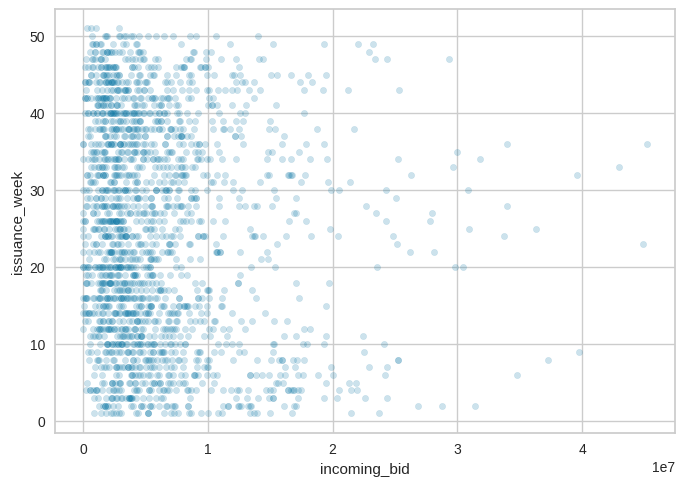

In [ ]:
df_train00.plot(kind = 'scatter', x = 'incoming_bid', y = 'issuance_week', alpha = 0.2)

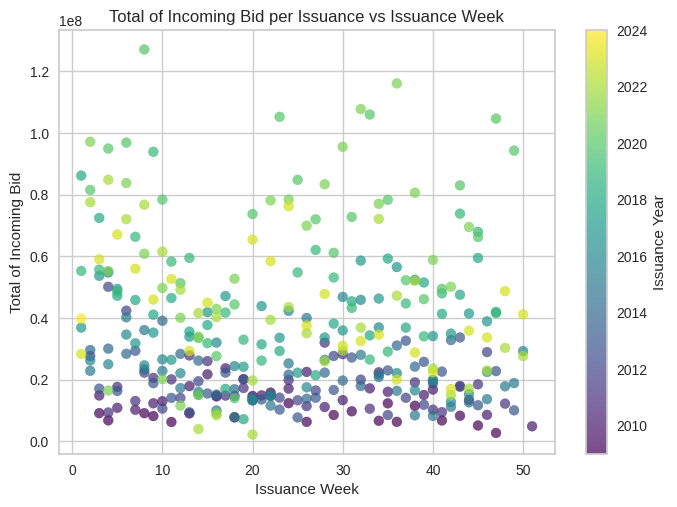

In [ ]:
# import matplotlib.pyplot as plt

grouped_series01 = df_train00.groupby(['issuance_date']).agg({
    'incoming_bid': 'sum',
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series01['issuance_year'] = grouped_series01['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series01['issuance_week'], grouped_series01['incoming_bid'], s=50, c=grouped_series01['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Total of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Total of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

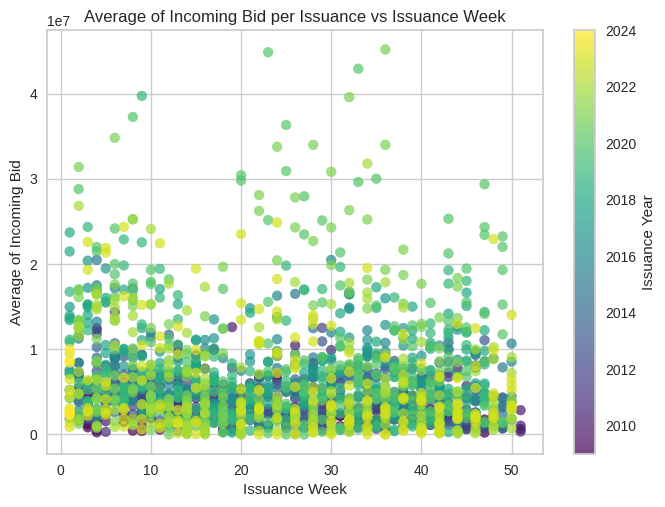

In [ ]:
# import matplotlib.pyplot as plt

grouped_series02 = df_train00.groupby(['issuance_date', 'issued_series']).agg({
    'incoming_bid': 'mean', #average
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series02['issuance_year'] = grouped_series02['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series02['issuance_week'], grouped_series02['incoming_bid'], s=50, c=grouped_series02['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Average of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Average of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

In [ ]:
# sns.catplot(x='issued_series', y='incoming_bid', data=grouped_series02,
#                 kind='boxen', col='issuance_year', col_wrap=2)

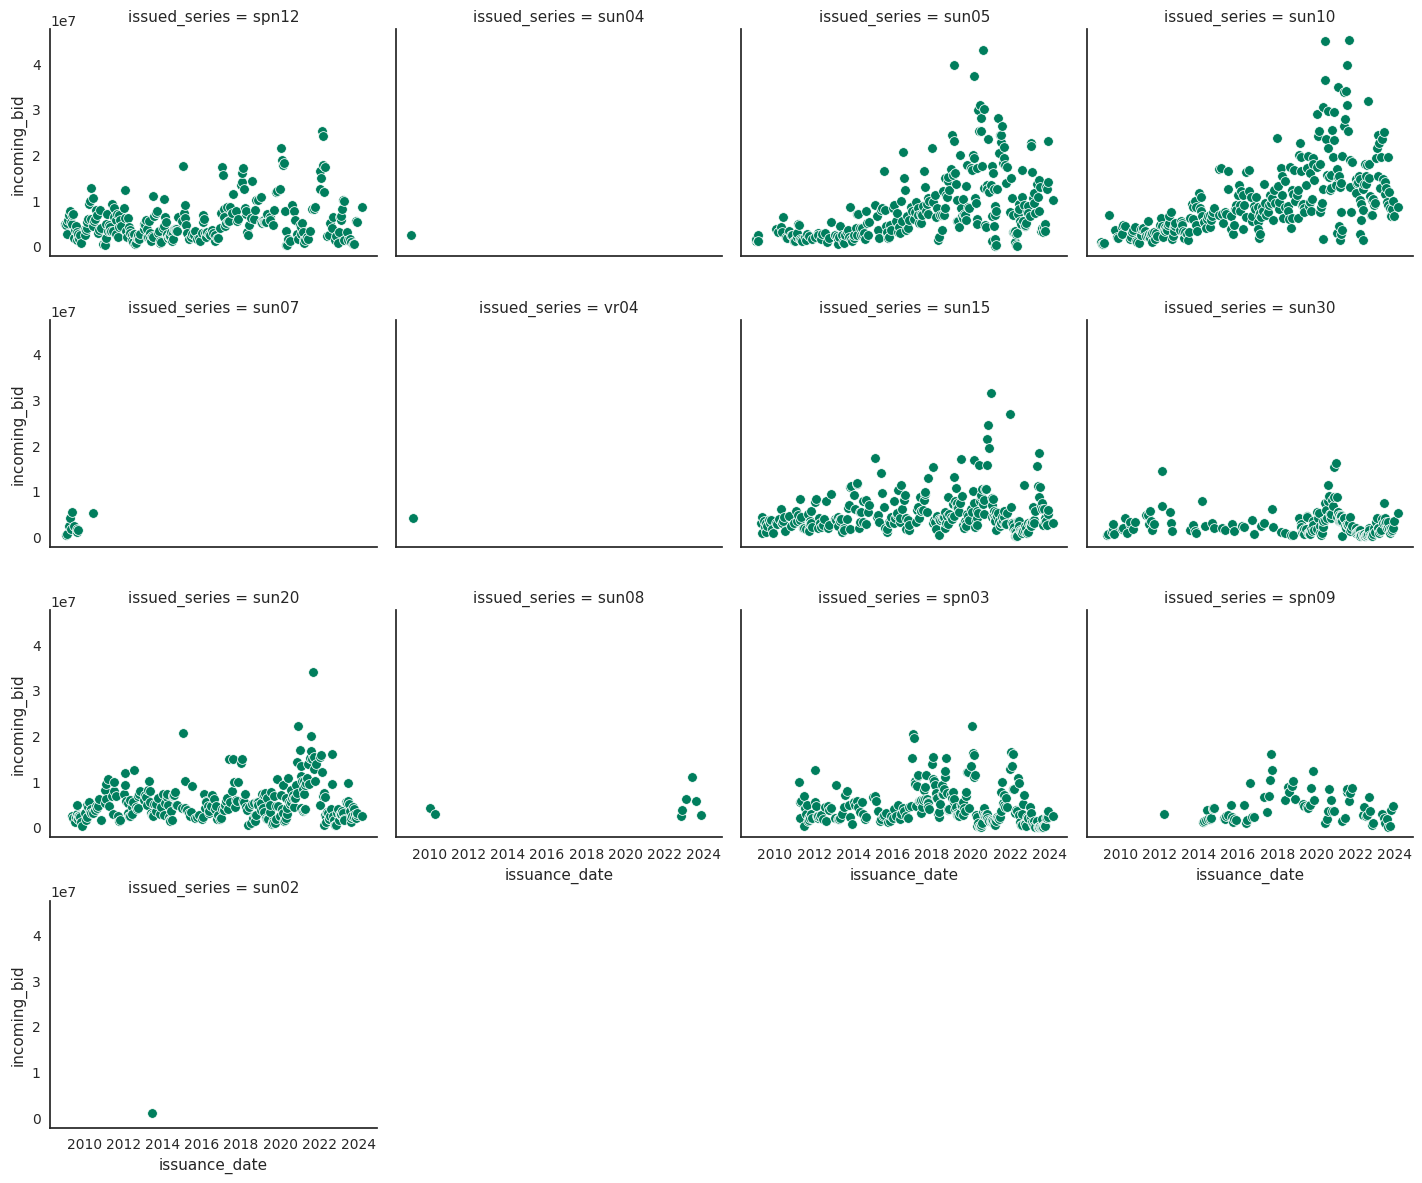

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch01 = sns.FacetGrid(df_train00, col='issued_series', col_wrap=4, height=3, aspect=1.2)
ch01.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [ ]:
corr_matrix = df_train00.corr()
corr_matrix['incoming_bid'].sort_values(ascending=False)

incoming_bid        1.000000
issuance_year       0.247464
investment_grade    0.193025
bi_covid            0.179578
eid_weeks          -0.010170
srbi_issuance      -0.046515
vix_indicator      -0.048545
issuance_week      -0.093471
gso_issuance       -0.100680
dayfrac            -0.101188
Name: incoming_bid, dtype: float64

In [ ]:
df_train01 = df_train00[~df_train00['issued_series'].isin(['sun04', 'sun02', 'vr04', 'spn09', 'sun07'])]

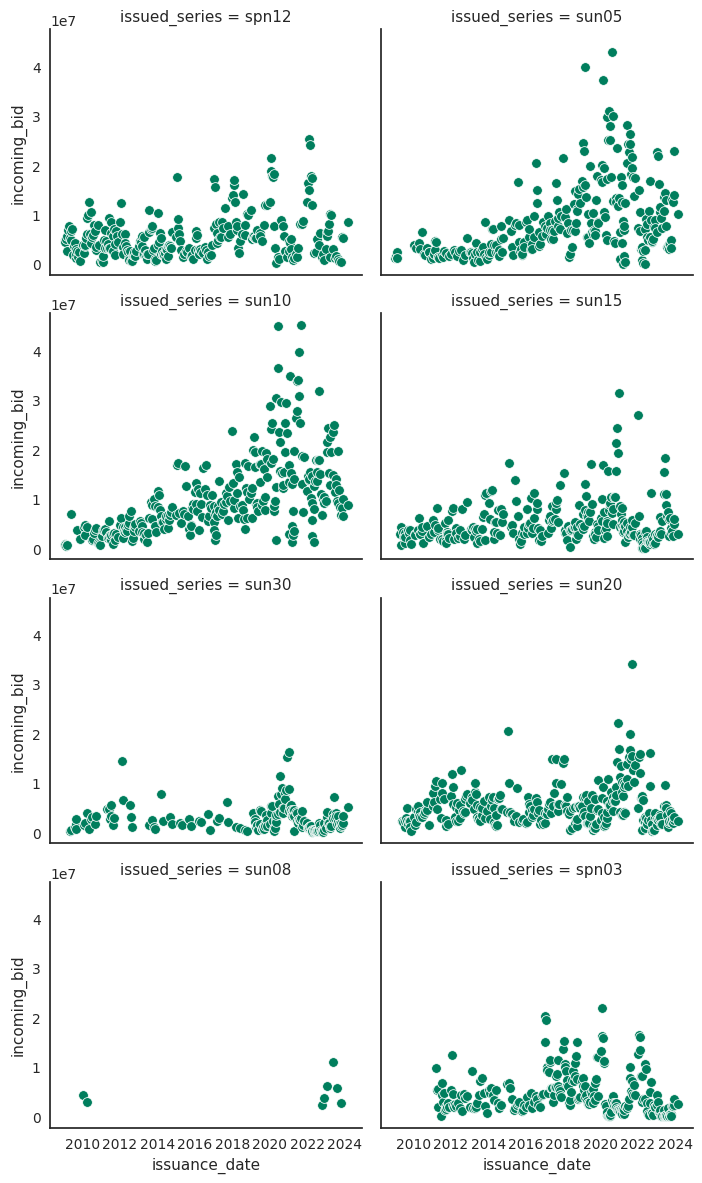

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch02 = sns.FacetGrid(df_train01, col='issued_series', col_wrap=2, height=3, aspect=1.2)
ch02.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [ ]:
# Get the order of categories
issd_series = df_train01['issued_series'].unique()

# Sort the order
issd_series.sort()

# Create a boxplot with sorted order
# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series, hue='issuance_year')

# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series)
# plt.show()

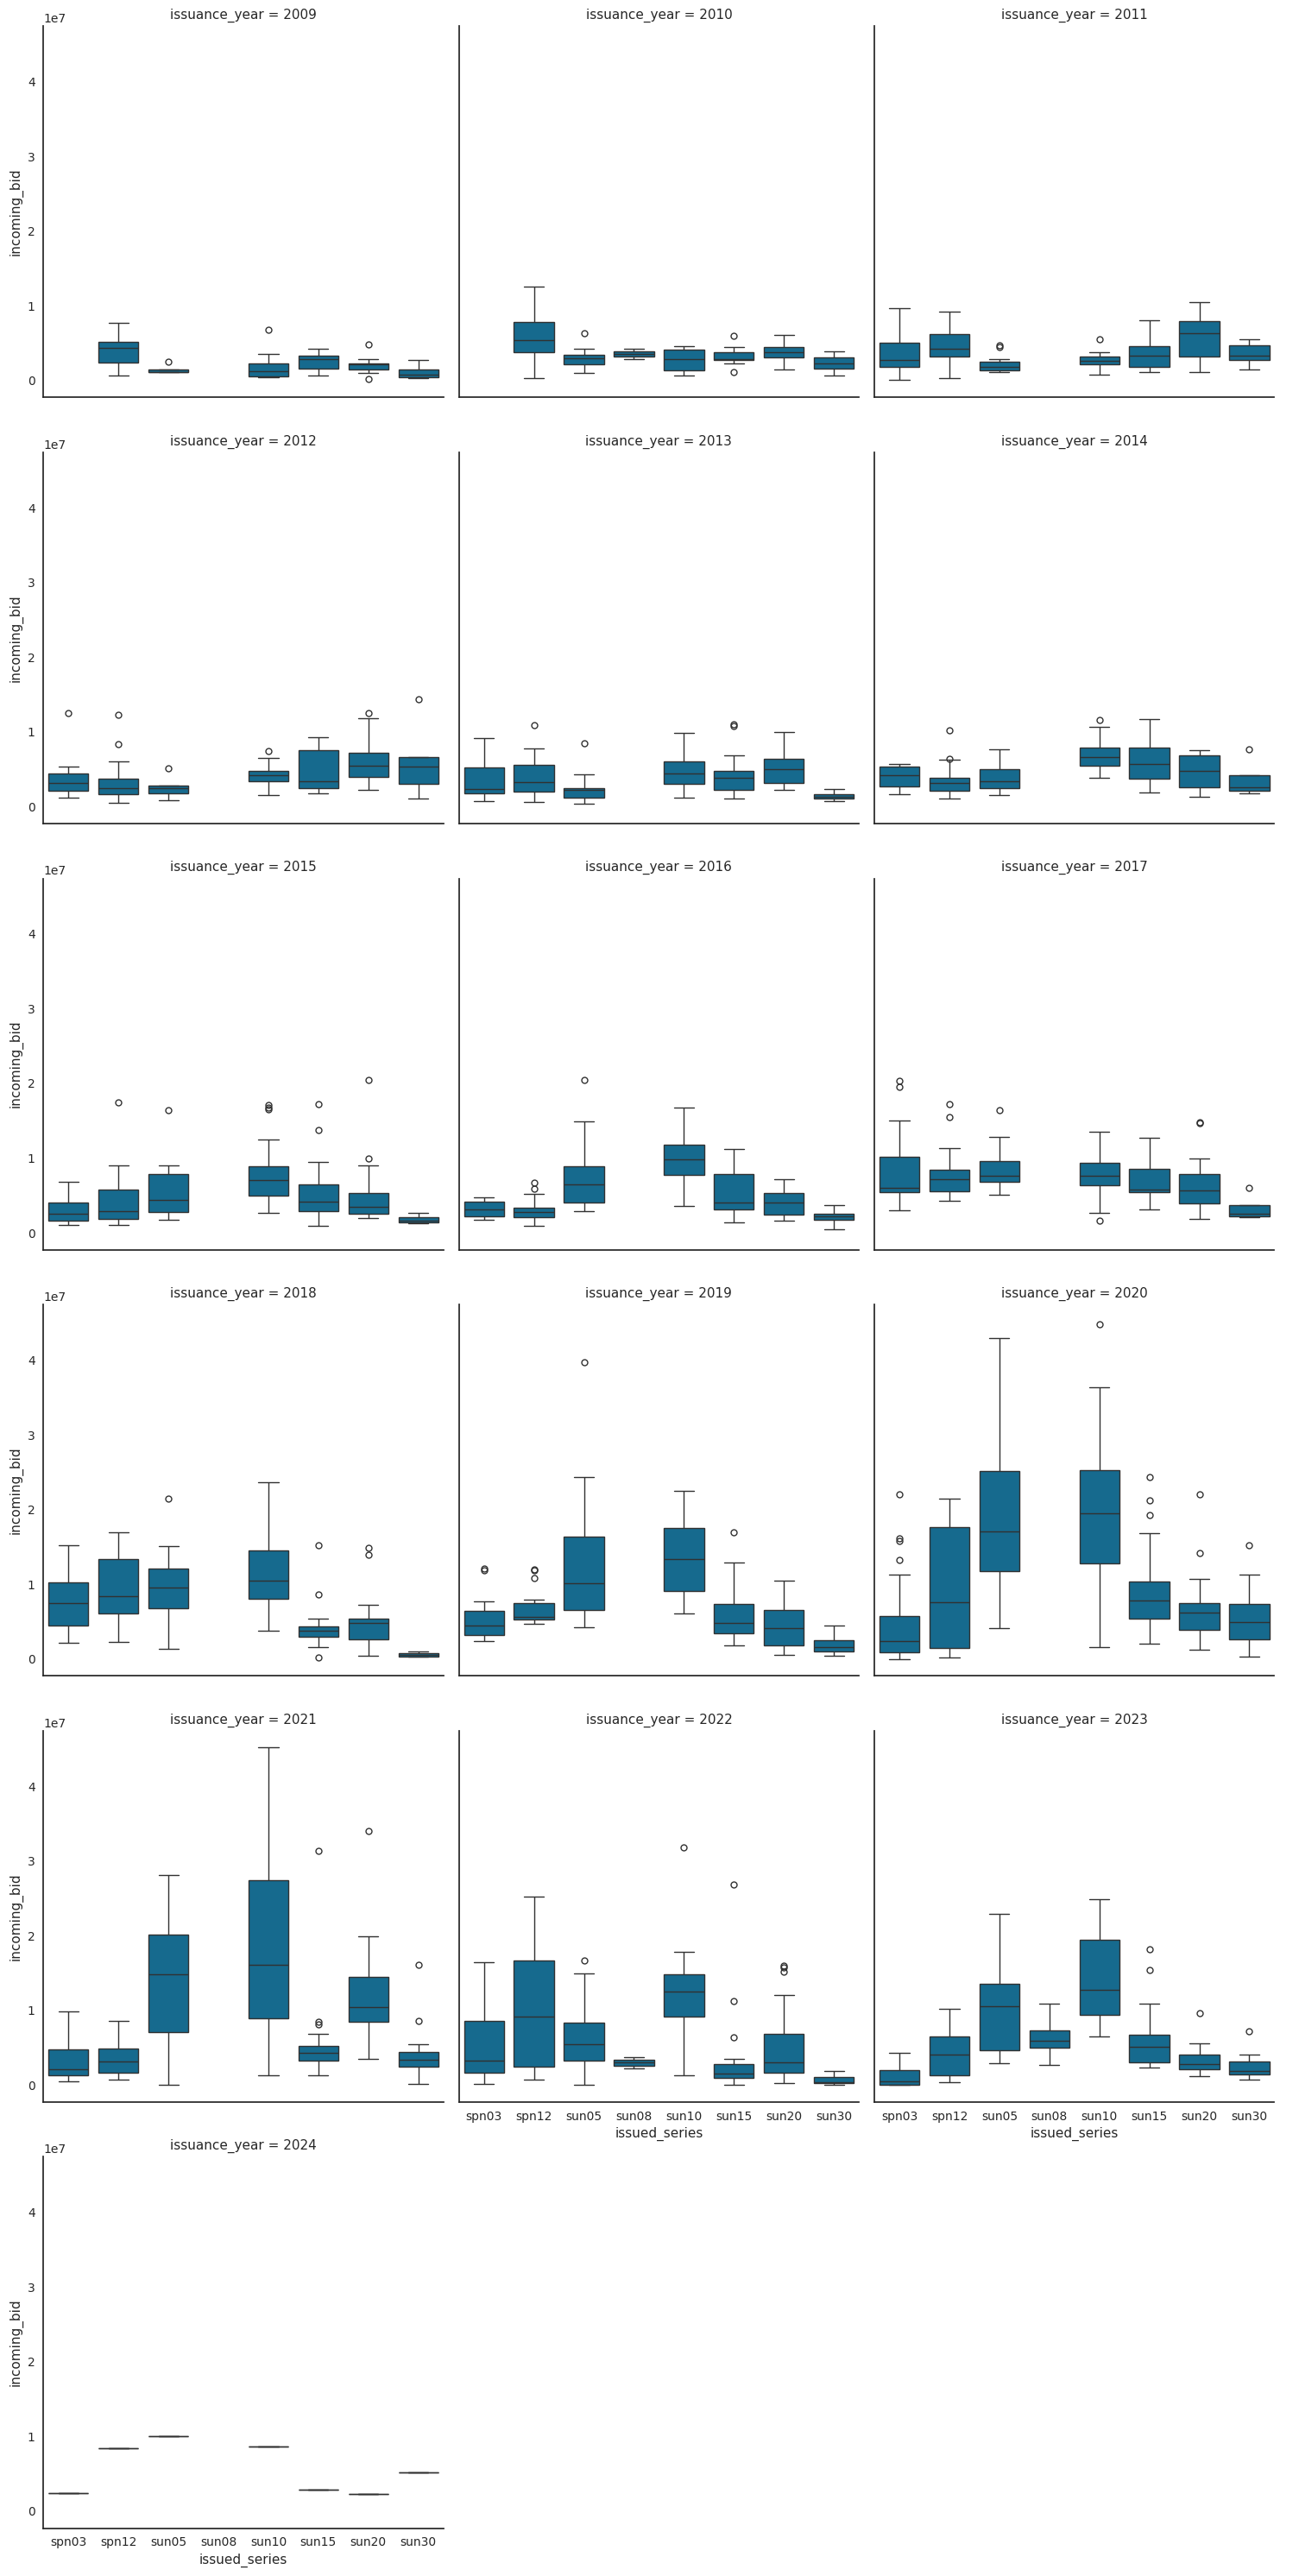

In [ ]:
sns.catplot(x='issued_series', y='incoming_bid', data=df_train01,
                order=issd_series, kind='box', col='issuance_year', col_wrap=3)

### Split: Biased

In [ ]:
# df_train02 = df_train01.sample(frac=0.9, random_state=786)
# df_unseen01 = df_train01.drop(df_train02.index)

# df_train02.reset_index(drop=True, inplace=True)
# df_unseen01.reset_index(drop=True, inplace=True)

# print('Data for Modeling: ' + str(df_train02.shape))
# print('Unseen Data For Predictions: ' + str(df_unseen01.shape))

In [ ]:
# print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

### Split: Stratified

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming df is your DataFrame and 'target_column' is the target variable
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in split.split(df_train01, df_train01['issued_series']):
    # Explicitly reset the index
    df_train02 = df_train01.iloc[train_index]
    df_unseen01 = df_train01.iloc[test_index]

# Explicitly reset the index for df_train02 and df_test01
# df_train02 = df_train02.reset_index(drop=True)
# df_unseen01 = df_unseen01.reset_index(drop=True)

# Display the shapes of the resulting sets (optional)
print("Train set shape:", df_train02.shape)
print("Test set shape:", df_unseen01.shape)

Train set shape: (1624, 12)
Test set shape: (181, 12)


In [ ]:
print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

Train: 
sun10    263
sun20    258
sun15    245
spn12    245
sun05    239
spn03    214
sun30    153
sun08      7
Name: issued_series, dtype: int64 

Test: 
sun10    29
sun20    29
sun15    27
spn12    27
sun05    27
spn03    24
sun30    17
sun08     1
Name: issued_series, dtype: int64


In [ ]:
# Identifying duplicates
duplicates = df_train02[df_train02.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)


Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, dayfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


In [ ]:
# Identifying duplicates
duplicates = df_unseen01[df_unseen01.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)

Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, dayfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


# Methods

## Setup

In [ ]:
session01 = setup(data=df_train02, target='incoming_bid', session_id=123,
                  test_data=df_unseen01,
                  categorical_features=['issued_series'],
                  ignore_features = ['issuance_date'])

,Description,Value
0,Session id,123
1,Target,incoming_bid
2,Target type,Regression
3,Original data shape,"(1805, 12)"
4,Transformed data shape,"(1805, 18)"
5,Transformed train set shape,"(1624, 18)"
6,Transformed test set shape,"(181, 18)"
7,Ignore features,1
8,Numeric features,9
9,Categorical features,1


## Compare Models

In [ ]:
best01 = compare_models(sort = 'rmse')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2348357.8591,12134757231391.5879,3462366.9950,0.6672,1.1349,0.9196,0.2400
lightgbm,Light Gradient Boosting Machine,2412189.8028,12638634147527.0117,3523814.2095,0.6555,1.1718,0.9005,0.7570
xgboost,Extreme Gradient Boosting,2409838.8000,12780492921241.5996,3550418.4500,0.6494,1.1652,0.8330,0.0840
rf,Random Forest Regressor,2467390.8711,13234552077186.1680,3605530.4790,0.6384,1.2016,1.0639,0.3660
gbr,Gradient Boosting Regressor,2961354.7480,18452610453574.0000,4266335.3266,0.4975,1.3023,1.3581,0.1230
dt,Decision Tree Regressor,2955859.0873,22299044158163.6719,4689481.4416,0.3763,1.1626,1.0651,0.0410
ridge,Ridge Regression,3695721.3611,26777923581973.4141,5155637.9830,0.2677,1.4885,2.5546,0.0400
lasso,Lasso Regression,3702640.7551,26775694246685.8516,5155846.5632,0.2676,1.4858,2.5548,0.0510
llar,Lasso Least Angle Regression,3703147.6757,26777310650395.2305,5156035.0094,0.2676,1.4870,2.5551,0.0420
lr,Linear Regression,3703153.0271,26777308939538.2734,5156035.2023,0.2676,1.4871,2.5551,0.4310


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

## Features

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2400638.0861,13296314600634.0898,3646411.1947,0.6457,0.6364,0.6282
1,1872671.6773,6545378678303.6553,2558393.7692,0.7476,1.6964,0.8344
2,2291429.9910,10527043938795.0176,3244540.6360,0.6923,1.4763,0.9582
3,2341972.2924,9110620920628.7207,3018380.5129,0.7052,1.2569,0.7619
4,2643034.9897,16794023631444.8574,4098051.1992,0.5832,1.1697,0.6830
5,2244640.7196,11271481893793.6074,3357302.7706,0.7591,0.5648,0.5367
6,2595796.3163,17230708525954.9219,4150988.8612,0.5217,1.2919,0.6754
7,2547926.9672,15357989730154.8027,3918927.1147,0.6262,1.4070,1.5687
8,2635544.6551,12706764826826.8418,3564654.9380,0.6230,1.4625,1.2366


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

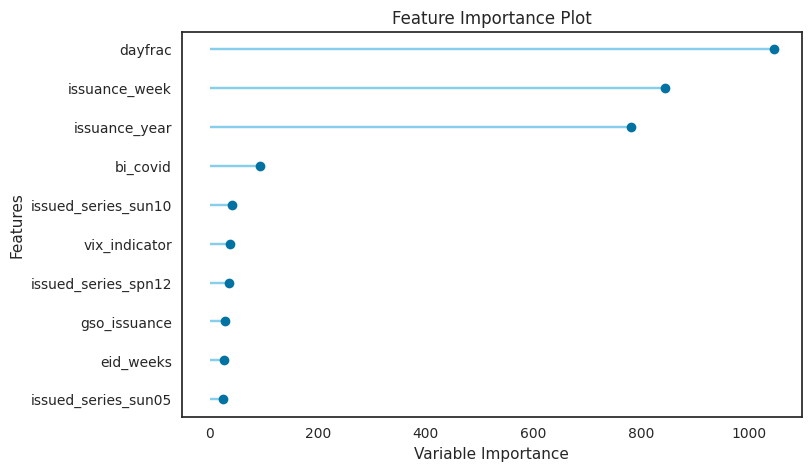

In [ ]:
plot_model(create_model('lightgbm'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2346771.7500,13412708909056.0000,3662336.5000,0.6426,0.6629,0.5961
1,1790433.7500,7419236712448.0000,2723827.5000,0.7139,1.5940,0.6540
2,2371135.0000,10762197139456.0000,3280578.7500,0.6854,1.5857,0.7624
3,2305804.7500,10327469064192.0000,3213638.0000,0.6658,1.2060,0.6585
4,2605323.0000,15761578917888.0000,3970085.5000,0.6088,1.3069,0.6190
5,2218914.7500,10140494331904.0000,3184414.2500,0.7832,0.6458,0.5656
6,2512412.5000,15052554895360.0000,3879762.2500,0.5822,1.0582,0.6255
7,2726883.2500,17471932203008.0000,4179944.0000,0.5747,1.4412,1.7228
8,2667759.7500,14123453644800.0000,3758118.2500,0.5810,1.4024,1.1195


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

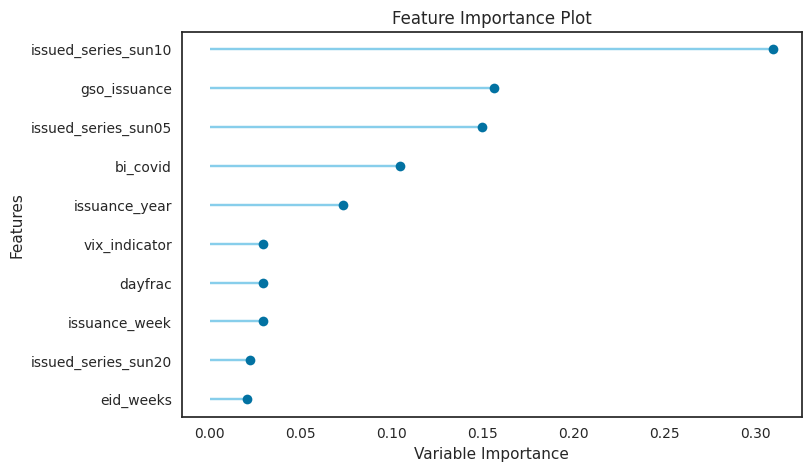

In [ ]:
plot_model(create_model('xgboost'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2425210.1595,13765927782966.7109,3710246.3238,0.6332,0.5484,0.5478
1,1844623.2209,7985041026156.5459,2825781.4895,0.6921,1.5564,0.6994
2,2148973.2086,9094578209238.8535,3015721.8388,0.7342,1.6535,2.0894
3,2101350.6012,9113445998043.6230,3018848.4556,0.7051,1.2563,0.5969
4,2429465.7500,13930557897251.6602,3732366.2598,0.6543,1.2741,0.5752
5,2319274.9506,11372145971776.1602,3372261.2550,0.7569,0.5627,0.5529
6,2561435.7006,16613843931079.3398,4076008.3330,0.5389,1.1700,0.5974
7,2617089.1358,14574250009635.4727,3817623.6076,0.6453,1.2683,1.6298
8,2444839.1173,11889097222587.8301,3448057.0214,0.6473,1.3839,1.0856


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

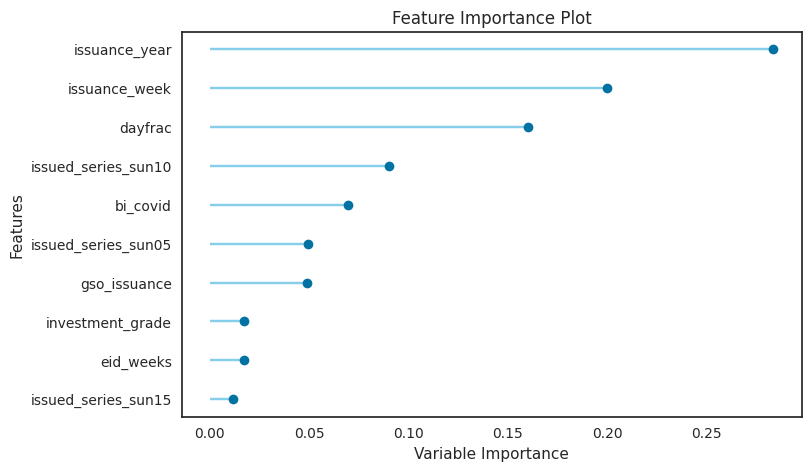

In [ ]:
plot_model(create_model('et'), plot='feature')

# Algorithms

## Light Gradient Boosting Machine

### Raw -- 65.55%

In [ ]:
# train a xgb model with default params
lightgbm_raw = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2400638.0861,13296314600634.0898,3646411.1947,0.6457,0.6364,0.6282
1,1872671.6773,6545378678303.6553,2558393.7692,0.7476,1.6964,0.8344
2,2291429.9910,10527043938795.0176,3244540.6360,0.6923,1.4763,0.9582
3,2341972.2924,9110620920628.7207,3018380.5129,0.7052,1.2569,0.7619
4,2643034.9897,16794023631444.8574,4098051.1992,0.5832,1.1697,0.6830
5,2244640.7196,11271481893793.6074,3357302.7706,0.7591,0.5648,0.5367
6,2595796.3163,17230708525954.9219,4150988.8612,0.5217,1.2919,0.6754
7,2547926.9672,15357989730154.8027,3918927.1147,0.6262,1.4070,1.5687
8,2635544.6551,12706764826826.8418,3564654.9380,0.6230,1.4625,1.2366


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 59.24%

In [ ]:
# tune hyperparameters of lightgbm
lightgbm_tuned = tune_model(lightgbm_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2500253.0608,13878456395921.8340,3725380.0338,0.6302,0.7664,0.7025
1,2284488.9071,9936977271498.7188,3152297.1420,0.6169,1.7928,0.8806
2,2655946.5652,13023872591417.0098,3608860.2898,0.6193,1.7906,2.4300
3,2413420.3603,10972266086378.5352,3312441.1069,0.6449,1.2178,0.7712
4,2796612.6164,17112428357203.3477,4136717.0990,0.5753,1.3702,0.8333
5,2701436.4996,14534529116602.6074,3812417.7521,0.6893,0.6435,0.6328
6,2817024.1297,20737313523656.7969,4553824.0550,0.4244,1.2844,0.7207
7,2940684.5032,18348692599239.2266,4283537.3932,0.5534,1.4653,1.3732
8,2842060.3322,15678951585686.8887,3959665.5901,0.5348,1.5134,1.5010


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 66.94%

In [ ]:

# Define a more comprehensive tuning grid for LightGBM
lightgbm_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4],
    'num_leaves': [15, 31, 63, 127],
    'min_split_gain': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample_freq': [0, 1, 2],
}

# Tune LightGBM model with custom grid and optimize for R2
lightgbm_modified = tune_model(lightgbm_raw, custom_grid=lightgbm_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2428686.8365,13241678843346.7461,3638911.7664,0.6472,0.6810,0.6002
1,1871821.8207,6993401285457.7637,2644503.9772,0.7304,1.7586,0.9667
2,2269428.2803,10096285566177.7363,3177465.2738,0.7049,1.7507,1.1917
3,2282778.0191,8942676302847.1035,2990430.7888,0.7106,1.2941,0.7142
4,2641389.8561,15468031433079.1387,3932941.8294,0.6161,1.3462,0.7084
5,2202531.3794,9783744500090.8574,3127897.7765,0.7909,0.5769,0.5037
6,2549687.8088,16334509102348.8984,4041597.3454,0.5466,1.3762,0.6787
7,2517364.8261,14834240152905.5000,3851524.3934,0.6389,1.4110,1.1055
8,2575651.9211,11876445499762.8730,3446221.9168,0.6477,1.4936,1.3491


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


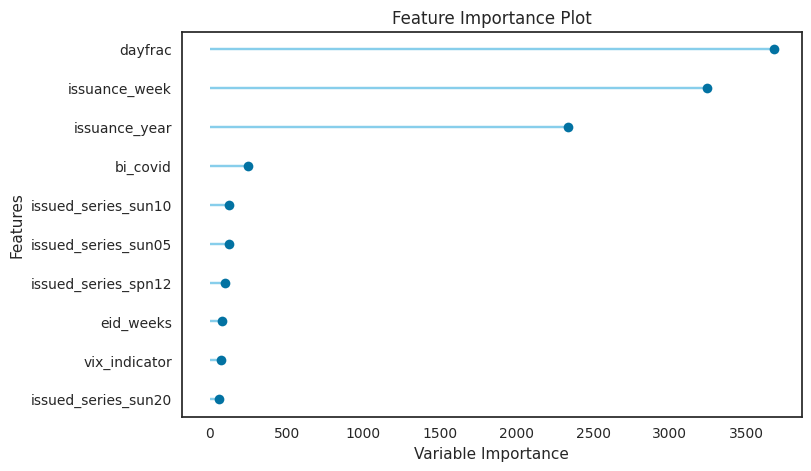

In [ ]:
plot_model(lightgbm_modified, plot = 'feature')

### Bagging -- 64.89%

In [ ]:
# ensemble with bagging
lightgbm_bagged = ensemble_model(lightgbm_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2419583.5215,13409467032137.6562,3661893.9133,0.6427,0.6089,0.6409
1,1796574.9584,6208572510048.3057,2491700.7264,0.7606,1.4898,0.8387
2,2372188.7782,10516680280336.9043,3242943.1510,0.6926,1.7638,2.1122
3,2343275.0102,9743290763208.5059,3121424.4766,0.6847,1.2299,0.7566
4,2719732.7696,16720833498245.4746,4089111.5781,0.5850,1.2098,0.7259
5,2284309.2864,11002174256216.2441,3316952.5556,0.7648,0.5642,0.5588
6,2578508.9457,17185761837136.0703,4145571.3523,0.5230,1.3115,0.6552
7,2530417.4391,15245724117825.0312,3904577.3290,0.6289,1.3873,1.4441
8,2676892.1680,13648565965042.9512,3694396.5630,0.5951,1.4379,1.2551


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 65.36%

In [ ]:
# ensemble with boosting
lightgbm_boosted = ensemble_model(lightgbm_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2480266.5138,14355013001703.0684,3788800.9979,0.6175,0.6385,0.6843
1,1893728.0346,6605759210874.3574,2570167.1562,0.7453,1.7766,1.0006
2,2347353.6152,10300853622651.9941,3209494.2939,0.6989,1.7123,1.1143
3,2354578.9964,9765792521675.1328,3125026.8034,0.6840,1.2642,0.7794
4,2644685.8682,15119782034824.3398,3888416.3916,0.6248,1.2758,0.7542
5,2337342.0633,11223657358317.6484,3350172.7356,0.7601,0.5927,0.5679
6,2559522.8932,16587242793937.8340,4072743.8900,0.5396,1.3275,0.6998
7,2653161.8885,15448578927899.4824,3930468.0291,0.6240,1.4431,1.7191
8,2731040.1624,13535379836567.1582,3679046.0498,0.5984,1.4876,1.4559


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

## Extreme Gradient Boosting

### Raw -- 64.94%

In [ ]:
# train a xgb model with default params
xgb_raw = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2346771.7500,13412708909056.0000,3662336.5000,0.6426,0.6629,0.5961
1,1790433.7500,7419236712448.0000,2723827.5000,0.7139,1.5940,0.6540
2,2371135.0000,10762197139456.0000,3280578.7500,0.6854,1.5857,0.7624
3,2305804.7500,10327469064192.0000,3213638.0000,0.6658,1.2060,0.6585
4,2605323.0000,15761578917888.0000,3970085.5000,0.6088,1.3069,0.6190
5,2218914.7500,10140494331904.0000,3184414.2500,0.7832,0.6458,0.5656
6,2512412.5000,15052554895360.0000,3879762.2500,0.5822,1.0582,0.6255
7,2726883.2500,17471932203008.0000,4179944.0000,0.5747,1.4412,1.7228
8,2667759.7500,14123453644800.0000,3758118.2500,0.5810,1.4024,1.1195


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 64.17%

In [ ]:
# tune hyperparameters of xgb
xgb_tuned = tune_model(xgb_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2573140.5000,16175520022528.0000,4021880.2500,0.5690,0.6248,0.6307
1,1936886.1250,7988281606144.0000,2826354.7500,0.6920,1.6385,0.7556
2,2114108.7500,8625257971712.0000,2936879.0000,0.7479,1.7219,2.7403
3,2189487.5000,9231553003520.0000,3038347.0000,0.7012,1.2938,0.6764
4,2505361.5000,14978713124864.0000,3870234.2500,0.6283,1.4057,0.6393
5,2283691.7500,10273615249408.0000,3205248.0000,0.7804,0.6502,0.5108
6,2604229.5000,15719812038656.0000,3964821.7500,0.5637,1.2959,0.6426
7,2725436.7500,16191473057792.0000,4023863.0000,0.6059,1.4328,1.5329
8,2745944.0000,13358262648832.0000,3654895.7500,0.6037,1.4909,1.1942


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


### Modifying -- 67.55%

In [ ]:
# define a more comprehensive tuning grid for XGBoost
xgb_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4]
}

# tune model with custom grid and optimize for R2
xgb_modified = tune_model(xgb_raw, custom_grid=xgb_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2398674.2500,13456343302144.0000,3668289.0000,0.6415,0.5709,0.6021
1,1718627.7500,5690177880064.0000,2385409.2500,0.7806,1.6708,0.6163
2,2274910.2500,10453184937984.0000,3233138.5000,0.6944,1.7197,1.3125
3,2116897.7500,8725830565888.0000,2953951.7500,0.7176,1.1982,0.6456
4,2513052.0000,14174622056448.0000,3764920.0000,0.6482,1.2677,0.6501
5,2251307.7500,10663968636928.0000,3265573.2500,0.7721,0.5550,0.5630
6,2549677.7500,16596002144256.0000,4073819.0000,0.5394,1.2899,0.6583
7,2570400.7500,14503125188608.0000,3808297.0000,0.6470,1.3911,1.1355
8,2603752.2500,12209195319296.0000,3494166.0000,0.6378,1.4443,1.2036


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


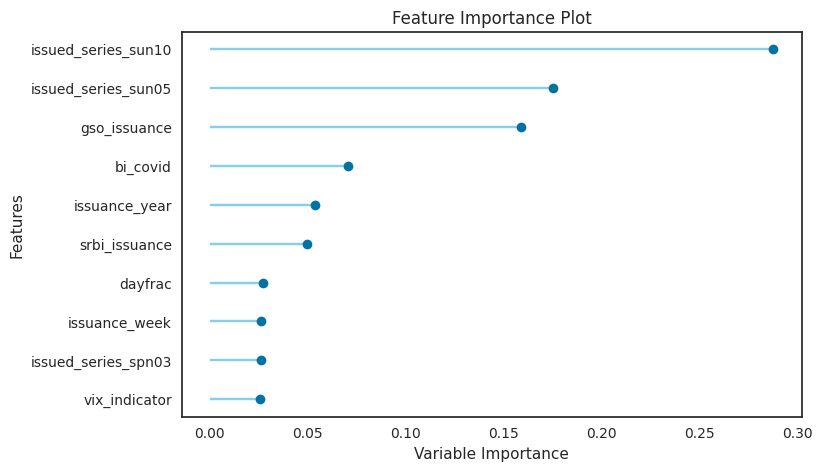

In [ ]:
plot_model(xgb_modified, plot = 'feature')

### Bagging -- 65.34%

In [ ]:
# ensemble with bagging
xgb_bagged = ensemble_model(xgb_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2318365.5000,13264608034816.0000,3642061.0000,0.6466,0.5718,0.5694
1,1804957.2500,6482135875584.0000,2546004.0000,0.7501,1.5771,0.7423
2,2267762.2500,9682547638272.0000,3111679.2500,0.7170,1.7234,0.6986
3,2351942.7500,10560585334784.0000,3249705.5000,0.6582,1.3182,0.7395
4,2584266.0000,15722897997824.0000,3965211.0000,0.6098,1.2704,0.6709
5,2284047.5000,11429553897472.0000,3380762.2500,0.7557,0.5388,0.5322
6,2480174.2500,16886742908928.0000,4109348.2500,0.5313,1.2650,0.6264
7,2595836.0000,15653945737216.0000,3956506.7500,0.6190,1.3886,1.1334
8,2661575.5000,13406151114752.0000,3661441.2500,0.6023,1.4225,1.2047


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 66.55%

In [ ]:
# ensemble with boosting
xgb_boosted = ensemble_model(xgb_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2409553.7500,14286282817536.0000,3779720.0000,0.6193,0.5886,0.5891
1,1775033.8750,6503618052096.0000,2550219.2500,0.7492,1.5947,0.6265
2,2199371.5000,10079652806656.0000,3174847.0000,0.7054,1.7211,1.3545
3,2194696.2500,9014657155072.0000,3002441.7500,0.7083,1.2209,0.7063
4,2476725.0000,14492927787008.0000,3806957.7500,0.6403,1.2721,0.6627
5,2258273.2500,11071474630656.0000,3327382.5000,0.7633,0.5472,0.5500
6,2518312.0000,15160631623680.0000,3893665.5000,0.5792,1.2363,0.6626
7,2714583.7500,16389712642048.0000,4048421.0000,0.6011,1.4262,1.4205
8,2753474.7500,13490393710592.0000,3672927.2500,0.5998,1.4700,1.3817


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

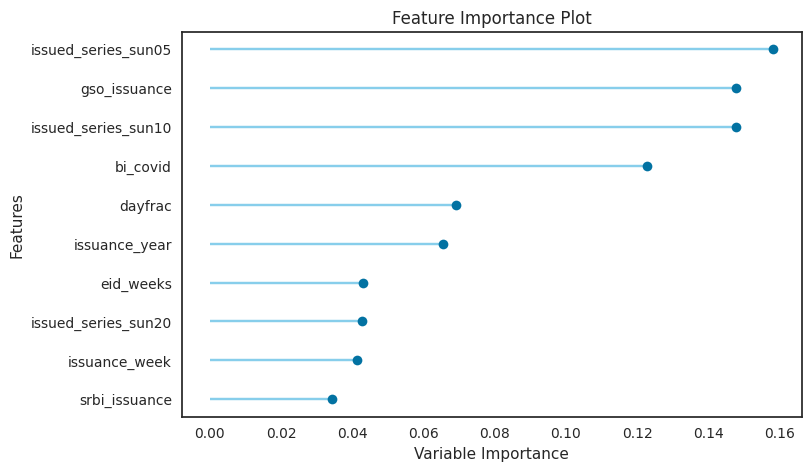

In [ ]:
plot_model(xgb_boosted, plot = 'feature')

## Extra Trees Regressor

### Raw -- 66.72%

In [ ]:
# train a et model with default params
et_raw = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2425210.1595,13765927782966.7109,3710246.3238,0.6332,0.5484,0.5478
1,1844623.2209,7985041026156.5459,2825781.4895,0.6921,1.5564,0.6994
2,2148973.2086,9094578209238.8535,3015721.8388,0.7342,1.6535,2.0894
3,2101350.6012,9113445998043.6230,3018848.4556,0.7051,1.2563,0.5969
4,2429465.7500,13930557897251.6602,3732366.2598,0.6543,1.2741,0.5752
5,2319274.9506,11372145971776.1602,3372261.2550,0.7569,0.5627,0.5529
6,2561435.7006,16613843931079.3398,4076008.3330,0.5389,1.1700,0.5974
7,2617089.1358,14574250009635.4727,3817623.6076,0.6453,1.2683,1.6298
8,2444839.1173,11889097222587.8301,3448057.0214,0.6473,1.3839,1.0856


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 54.74%

In [ ]:
# tune hyperparameters of et
et_tuned = tune_model(et_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2811118.4809,16835058585071.1465,4103054.7870,0.5514,0.6654,0.8040
1,2126476.9169,8967904891779.1973,2994646.0378,0.6542,1.7907,1.0374
2,2828832.1555,14821194549361.7031,3849830.4572,0.5668,1.9029,5.3433
3,2480823.2201,11336813455383.4961,3367018.4816,0.6331,1.3360,0.8389
4,3000679.5533,19735636646900.0078,4442480.9113,0.5102,1.3845,0.9584
5,2707352.4092,16473865143886.2148,4058800.9490,0.6479,0.6251,0.7138
6,2877903.3595,21420932039246.2891,4628275.2770,0.4054,1.3735,0.8501
7,2929746.7255,19331449832542.0508,4396754.4658,0.5295,1.4372,2.5786
8,2976256.2152,17057568289871.3984,4130080.9060,0.4939,1.5624,1.7218


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 61.18%

In [ ]:
# define a more comprehensive tuning grid for Random Forest Regressor
et_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 4, 8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
et_modified = tune_model(et_raw, custom_grid=et_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2533207.6844,13184677822966.4473,3631071.1674,0.6487,0.6277,0.7212
1,1916489.1433,7360123961943.3555,2712954.8396,0.7162,1.7561,1.1741
2,2466083.3778,11588881084867.4746,3404244.5689,0.6612,1.8246,3.6516
3,2311583.3394,10818410427797.5391,3289135.2097,0.6499,1.3086,0.7547
4,2866212.7671,17573190064218.0996,4192038.8911,0.5639,1.3788,0.8582
5,2493773.2273,14917867215710.6504,3862365.4948,0.6811,0.5798,0.6259
6,2663678.7017,18065684588514.5547,4250374.6410,0.4986,1.3066,0.7769
7,2831809.0497,18498263238232.9766,4300960.7343,0.5498,1.3858,2.3779
8,2669130.7379,13524139733017.7871,3677518.1486,0.5988,1.4673,1.5911


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Bagging -- 66.98%

In [ ]:
# ensemble with bagging
et_bagged = ensemble_model(et_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2454610.7143,13428117089763.1191,3664439.5328,0.6422,0.5643,0.5886
1,1748016.0274,6794893065612.7383,2606701.5682,0.7380,1.5562,0.7292
2,2263253.6301,9787851001716.4219,3128554.1392,0.7139,1.7418,2.3756
3,2174987.0235,9255855386341.2773,3042343.7324,0.7005,1.2560,0.6553
4,2454349.9683,13242896041386.1055,3639079.0100,0.6713,1.2679,0.6290
5,2323691.4834,11863673037772.3379,3444368.3075,0.7464,0.5497,0.5610
6,2523059.6064,17042715038055.9785,4128282.3351,0.5270,1.2325,0.6151
7,2626822.3466,14902123392449.8242,3860326.8505,0.6373,1.2956,1.7981
8,2403231.3111,10967684344584.2461,3311749.4387,0.6746,1.4127,1.1415


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 67.46%

In [ ]:
# ensemble with boosting
et_boosted = ensemble_model(et_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2423834.5297,13499851470785.6973,3674214.4019,0.6403,0.5577,0.5903
1,1888347.6779,7472832123882.4004,2733648.1346,0.7119,1.6585,0.7932
2,2198991.9305,9212838973287.7402,3035265.8818,0.7307,1.7360,2.5302
3,2201417.1779,9380802721824.1387,3062809.6124,0.6964,1.2725,0.6535
4,2491696.8827,14008309681249.4512,3742767.6499,0.6523,1.2824,0.6159
5,2256634.1414,11417681091553.9453,3379005.9325,0.7559,0.5376,0.5357
6,2461781.0257,15631035115225.7207,3953610.3899,0.5661,1.2779,0.6105
7,2678209.5082,14908028415503.2793,3861091.6093,0.6371,1.3402,1.8589
8,2492774.2515,11490165654283.5879,3389714.6863,0.6591,1.4051,1.2450


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

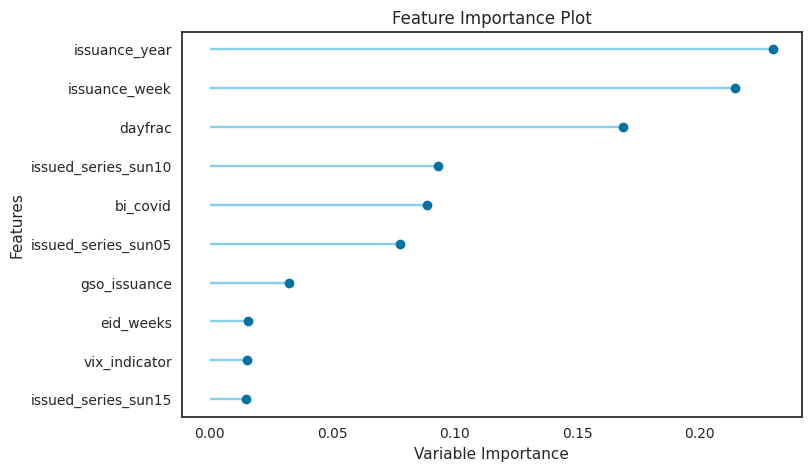

In [ ]:
plot_model(et_boosted, plot = 'feature')

# Choosen

## Blended -- 58.11%

In [ ]:
# Blend the Boosted Ensembles
blended = blend_models(estimator_list=[lightgbm_modified, xgb_modified, et_boosted], fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2293475.5609,12097848973557.7539,3478196.2241,0.6777,0.5414,0.5610
1,1681656.1540,5593113183483.4912,2364976.3600,0.7843,1.6314,0.6170
2,2138572.4028,8945925590238.6191,2990974.0203,0.7385,1.6612,1.2902
3,2054518.0545,7944913578685.4180,2818672.3078,0.7429,1.1779,0.6402
4,2400455.0991,13388716228540.9219,3659059.4732,0.6677,1.2619,0.6237
5,2160095.3271,9796195999935.0898,3129887.5379,0.7906,0.5225,0.5148
6,2427943.9697,15459650970189.7285,3931876.2659,0.5709,1.2630,0.6152
7,2468100.2034,13563827215935.5039,3682910.1558,0.6699,1.3687,1.3218
8,2391403.8051,10100704422443.9082,3178160.5407,0.7003,1.4275,1.2224


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
predict_model(blended);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2297650.0944,12285746783554.2832,3505102.9633,0.5811,0.8682,0.5460


In [ ]:
# plot_model(blended, plot = 'residuals')

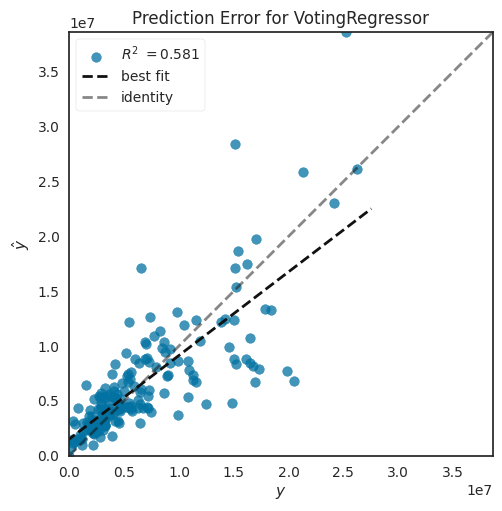

In [ ]:
plot_model(blended, plot = 'error')

## Stacked -- 55.47%

In [ ]:
stacked = stack_models(estimator_list=[lightgbm_modified, xgb_modified, et_boosted])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2377310.6891,12431420668561.2715,3525821.9848,0.6688,0.5702,0.5762
1,1672379.8749,5768365053567.4287,2401742.0872,0.7776,1.6065,0.7334
2,2115657.3848,8588440004200.9004,2930604.0340,0.7489,1.5967,0.9811
3,2074586.0376,8034726765793.1904,2834559.3601,0.7400,1.1924,0.6209
4,2392321.4181,13357670232097.9082,3654814.6645,0.6685,1.2132,0.5801
5,2147432.5417,9695129376474.8789,3113700.2708,0.7928,0.5264,0.4924
6,2443033.2149,15236447895539.7129,3903389.2831,0.5771,1.2539,0.6354
7,2464036.1253,13508065967019.3828,3675332.0894,0.6712,1.3339,0.8962
8,2355116.8041,9817244673073.8086,3133248.2623,0.7087,1.4093,1.1637


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
predict_model(stacked);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,2346186.1787,13060185147366.8730,3613887.8161,0.5547,1.1437,0.4870


In [ ]:
# plot_model(stacked, plot = 'residuals')

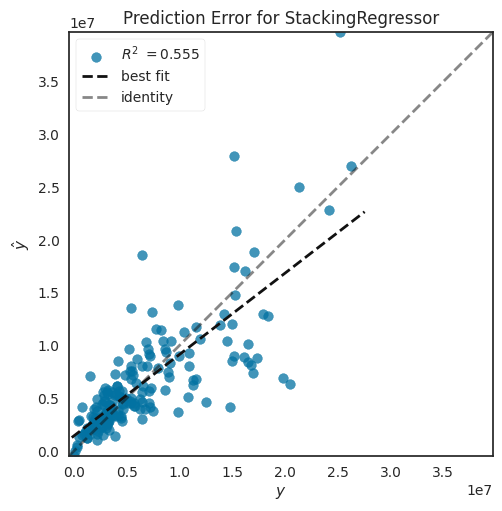

In [ ]:
plot_model(stacked, plot = 'error')

## Finalizing -- 94.19%

In [ ]:
final = finalize_model(blended)
predict_model(final);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,904467.5979,1705394824859.3301,1305907.6632,0.9419,0.8486,0.2323


In [ ]:
save_model(final, '/content/drive/MyDrive/00database/20240129_blended01')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['issuance_year', 'issuance_week',
                                              'dayfrac', 'eid_weeks',
                                              'srbi_issuance', 'vix_indicator',
                                              'bi_covid', 'gso_issuance',
                                              'investment_grade'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['issued_series'],
                                     transformer=SimpleImputer(...
                                                            max_cat_to_onehot=None,
                                                            max_delta_step=None,
                                                            max_depth=11,
                                                            max_leaves=

# Lelang 16 Jan 2024

## Load

In [82]:
lelang20240116 = pd.read_excel('/content/drive/MyDrive/00database/dbpodem_20240116.xlsx', sheet_name='lelang20240116')
lelang20240116['issuance_date'] = pd.to_datetime(lelang20240116['issuance_date'], format='%d/%m/%Y')
lelang20240116.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     7 non-null      object        
 1   issuance_date     7 non-null      datetime64[ns]
 2   issuance_year     7 non-null      int64         
 3   issuance_week     7 non-null      int64         
 4   dayfrac           7 non-null      int64         
 5   eid_weeks         7 non-null      int64         
 6   srbi_issuance     7 non-null      int64         
 7   vix_indicator     7 non-null      int64         
 8   bi_covid          7 non-null      int64         
 9   gso_issuance      7 non-null      int64         
 10  investment_grade  7 non-null      int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 744.0+ bytes


## Model: 20240129_blended01

In [83]:
# predict model on new_data
predict03= predict_model(final, data = lelang20240116)
predict03

,issued_series,issuance_date,issuance_year,issuance_week,dayfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,prediction_label
0,spn03,2024-01-16,2024,1,92,0,1,0,0,0,1,2.826153e+06
1,spn12,2024-01-16,2024,1,366,0,1,0,0,0,1,6.051871e+06
2,sun05,2024-01-16,2024,1,1916,0,1,0,0,0,1,1.037764e+07
3,sun10,2024-01-16,2024,1,3683,0,1,0,0,0,1,1.135965e+07
4,sun15,2024-01-16,2024,1,5264,0,1,0,0,0,1,4.875544e+06
5,sun20,2024-01-16,2024,1,7090,0,1,0,0,0,1,2.600471e+06
6,sun30,2024-01-16,2024,1,11138,0,1,0,0,0,1,4.076340e+06


In [84]:
# @title Lelang 20240116: Per series

# !pip install --upgrade pip
# !pip install tabulate

import tabulate

# Incoming bid per series
predict04 = predict03[['issued_series', 'issuance_date', 'prediction_label']]

# Create a new column with formatted dates
predict04['issuance_date'] = predict04['issuance_date'].dt.strftime('%Y-%m-%d')

# Format the 'prediction_label' column
predict04['prediction_label'] = predict04['prediction_label'].apply(lambda x: '{:,.2f} trillion'.format(x / 1_000_000))

# Convert the DataFrame to a list of dictionaries for tabulate
table_data = predict04.to_dict(orient='records')

# Specify the column alignments
column_alignments = {'issued_series': 'left', 'issuance_date': 'center', 'prediction_label': 'right'}

# Display the formatted DataFrame using tabulate
formatted_table = tabulate.tabulate(table_data, headers="keys", floatfmt=".2f", showindex=False, colalign=list(column_alignments.values()), tablefmt="pipe")

print(formatted_table)

| issued_series   |  issuance_date  |   prediction_label |
|:----------------|:---------------:|-------------------:|
| spn03           |   2024-01-16    |      2.83 trillion |
| spn12           |   2024-01-16    |      6.05 trillion |
| sun05           |   2024-01-16    |     10.38 trillion |
| sun10           |   2024-01-16    |     11.36 trillion |
| sun15           |   2024-01-16    |      4.88 trillion |
| sun20           |   2024-01-16    |      2.60 trillion |
| sun30           |   2024-01-16    |      4.08 trillion |


In [85]:
# @title Lelang 20240116: Total

# Sum total incoming bid
incoming_bid = predict03['prediction_label'].sum()

# Round to two decimal places
rounded_bid = round(incoming_bid, 2)
formatted_rounded_bid = 'Rp{:,.2f} million'.format(rounded_bid)

# Adjust to the nearest thousand
formatted_incoming_bid = 'Rp{:,.2f} trillion'.format(rounded_bid / 1000000)

output_message = f"""
According to a blended machine learning algorithm model with an R-squared value of 58.96%,
the estimated incoming bid for the next issuance is approximately {formatted_rounded_bid}
or {formatted_incoming_bid}.
"""

print(output_message)



According to a blended machine learning algorithm model with an R-squared value of 58.96%,
the estimated incoming bid for the next issuance is approximately Rp42,167,671.54 million
or Rp42.17 trillion.



## Model: 20240129_stacked01

In [79]:
# load model
stacked01_20240129 = load_model("/content/drive/MyDrive/00database/20240129_stacked01")

# predict model on new_data
predict05 = predict_model(stacked01_20240129, data = lelang20240116)
predict05

Transformation Pipeline and Model Successfully Loaded


,issued_series,issuance_date,issuance_year,issuance_week,dayfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,prediction_label
0,spn03,2024-01-16,2024,1,92,0,1,0,0,0,1,2.968278e+06
1,spn12,2024-01-16,2024,1,366,0,1,0,0,0,1,3.063617e+06
2,sun05,2024-01-16,2024,1,1916,0,1,0,0,0,1,1.165683e+07
3,sun10,2024-01-16,2024,1,3683,0,1,0,0,0,1,1.158766e+07
4,sun15,2024-01-16,2024,1,5264,0,1,0,0,0,1,7.787325e+06
5,sun20,2024-01-16,2024,1,7090,0,1,0,0,0,1,1.692462e+06
6,sun30,2024-01-16,2024,1,11138,0,1,0,0,0,1,4.013604e+06


In [80]:
# @title Lelang 20240116: Per series

# !pip install --upgrade pip
# !pip install tabulate

import tabulate

# Incoming bid per series
predict06 = predict05[['issued_series', 'issuance_date', 'prediction_label']]

# Create a new column with formatted dates
predict06['issuance_date'] = predict06['issuance_date'].dt.strftime('%Y-%m-%d')

# Format the 'prediction_label' column
predict06['prediction_label'] = predict06['prediction_label'].apply(lambda x: '{:,.2f} trillion'.format(x / 1_000_000))

# Convert the DataFrame to a list of dictionaries for tabulate
table_data = predict06.to_dict(orient='records')

# Specify the column alignments
column_alignments = {'issued_series': 'left', 'issuance_date': 'center', 'prediction_label': 'right'}

# Display the formatted DataFrame using tabulate
formatted_table = tabulate.tabulate(table_data, headers="keys", floatfmt=".2f", showindex=False, colalign=list(column_alignments.values()), tablefmt="pipe")

print(formatted_table)

| issued_series   |  issuance_date  |   prediction_label |
|:----------------|:---------------:|-------------------:|
| spn03           |   2024-01-16    |      2.97 trillion |
| spn12           |   2024-01-16    |      3.06 trillion |
| sun05           |   2024-01-16    |     11.66 trillion |
| sun10           |   2024-01-16    |     11.59 trillion |
| sun15           |   2024-01-16    |      7.79 trillion |
| sun20           |   2024-01-16    |      1.69 trillion |
| sun30           |   2024-01-16    |      4.01 trillion |


In [81]:
# @title Lelang 20240116: Total

# Sum total incoming bid
incoming_bid = predict05['prediction_label'].sum()

# Round to two decimal places
rounded_bid = round(incoming_bid, 2)
formatted_rounded_bid = 'Rp{:,.2f} million'.format(rounded_bid)

# Adjust to the nearest thousand
formatted_incoming_bid = 'Rp{:,.2f} trillion'.format(rounded_bid / 1000000)

output_message = f"""
According to a blended machine learning algorithm model with an R-squared value of 58.11%,
the estimated incoming bid for the next issuance is approximately {formatted_rounded_bid}
or {formatted_incoming_bid}.
"""

print(output_message)



According to a blended machine learning algorithm model with an R-squared value of 58.11%,
the estimated incoming bid for the next issuance is approximately Rp42,769,776.46 million
or Rp42.77 trillion.

